In [1]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

# first used in exercise one
import midterm as mt
from sklearn import preprocessing # for scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# first used in exercise two
# TODO

In [77]:
# import importlib
# importlib.reload(mt)

<module 'midterm' from '/Users/andrewenfield/work/github/Data558/Midterm/midterm.py'>

# Exercise One

## Derive the coordinate minimization formula

**TODO** insert images showing derivation

## Implement coordinate descent

I've submitted my implementation in the midterm.py file. I use this implementation in this notebook - I imported the module above and gave it the alias 'mt'. In addition, in case it helps understand how my implementation works, I've included the tests I wrote as part of doing the implementation. These are in the file midterm-test.py.

In more detail, here's where the requested functions are implemented in midterm.py:

* *Write a function that computes the solution to the partial minimization problem.* See the function minimize_beta_term (which calls the a_term and c_term functions).
* *Write a function computeobj that computes and returns F(β) for any β.* See the function elasticnet_objective.
* *Write a function cycliccoorddescent that implements the cyclic coordinate descent algorithm. The function takes as input the initial point and the maximum number of iterations. The stopping criterion is the maximum number of iterations.* See the function cycliccoorddescent. This function calls the function coorddescent, which handles the the main algorithm for both cyclic and random implementations - this function passes a sequential set of j values.
* *Write a function pickcoord that samples uniformly from the set {1, . . . , d} .* I implemented this functionality in the get_sequence_of_js function. This function returns a list of values that define the specific beta values/coefficients to be minimized. When called with the random parameter equal to False, the function returns a sequential list of j values (i.e., [1 2 3 1 2 3 ...]). When called with random equal to True, the function samples uniformly from the set {1,...,d} and returns a list of j values built from these random selections.
* *Write a function randcoorddescent that implements the randomized coordinate descent algo- rithm. The function takes as input the initial point and the maximum number of iterations. The stopping criterion is the maximum number of iterations.* See the function randcoorddescent. This function calls the function coorddescent, which handles the the main algorithm for both cyclic and random implementations - this function passes a set of j values that have been randomly chosen.

## Load and standardize data

*Consider the Hitters dataset from [2]. You may download it from [here](https://raw. githubusercontent.com/selva86/datasets/master/Hitters.csv). Standardize the data (i.e., center the predictors and the outputs and divide them by their standard deviations).*

In [3]:
h = pd.read_csv('Hitters.csv')
h.shape

(322, 20)

In [4]:
h.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')

In [5]:
# remove rows w/ empty values - i think this is only those w/ no salary
h = h.dropna()
h.shape

(263, 20)

In [6]:
# convert categorical vars to dummy variables
h = pd.get_dummies(h)
h.shape

(263, 23)

In [7]:
h[:1]

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1


In [8]:
# split into features and the value to predict (X and y)
# scale all features so each col has mean zero and std 1
X_scaled = preprocessing.scale(h.drop('Salary', axis=1))
y_scaled = preprocessing.scale(h['Salary']) 

(X_scaled.shape, y_scaled.shape)

((263, 22), (263,))

## Find best lambda via cross-validation

*In the remainder, the iteration counter iter refers here to t/d, that is the effective number of passes over all coordinates. Set the maximum number of iterations to 1000. Set α = 0.9. Run your own implementation of cross-validation on the Hitters dataset to find the optimal value of λ.*

In [57]:
# 1000 is a lot, but it's what the problem specifies; multiply by the number
# of features to get to an effective number of iterations of 1000
feature_count = X_scaled.shape[1] 
actual_iteration_count = 1000 * feature_count
(feature_count, actual_iteration_count)

(22, 22000)

**TODO** update below to use the correct number of iterations per the answer to my disc group question.

In [39]:
def train_and_test_single_fold(X_full, y_full, train_index, test_index, lam, alpha):
    """
    Train using the data identified by the indices in train_index, and then test
    (and return MSE) using the data identified by the indices in test_index.
    """
    beta_vals = mt.randcoorddescent(X_full[train_index], y_full[train_index], 
                                    lam, alpha, max_iter=1000)
                                    #lam, alpha, max_iter=actual_iteration_count)

    final_coefs = mt.get_final_coefs(beta_vals)
    
    return mean_squared_error(y_full[test_index], X_full[test_index].dot(final_coefs))

In [40]:
def train_and_test_for_all_folds(X_full, y_full, train_indices, test_indices, lam, alpha):
    """
    Train and test for all folds - for now, 10 folds, hard-coded. Return the mean of the 
    set of MSE values from all folds."""
    mses = [train_and_test_single_fold(X_full, y_full, 
                                       train_indices[i], test_indices[i], lam, alpha) for i in range(10)]
    return(np.mean(mses))

In [41]:
# get arrays with 10 sets of test and train indices - one for each fold
kf = KFold(10, shuffle=True, random_state=42)

train_indices_list = []
test_indices_list = []
for train_index, test_index in kf.split(X_scaled):
    train_indices_list.append(train_index)
    test_indices_list.append(test_index)
    
train_indices = np.array(train_indices_list)
test_indices = np.array(test_indices_list)

In [42]:
lambdas = np.logspace(-5, 0.1, num=10)
lambdas

array([  1.00000000e-05,   3.68694506e-05,   1.35935639e-04,
         5.01187234e-04,   1.84784980e-03,   6.81292069e-03,
         2.51188643e-02,   9.26118728e-02,   3.41454887e-01,
         1.25892541e+00])

In [43]:
alpha = 0.9

In [44]:
# and finally, do 10-fold cross validation for each value of lambda, and
# show the mean of each set's MSEs
mses_by_lambda = [train_and_test_for_all_folds(X_scaled, y_scaled, 
                        train_indices, test_indices, lam, alpha) for lam in lambdas]
list(zip(lambdas, mses_by_lambda))

[(1.0000000000000001e-05, 0.55631811436675827),
 (3.6869450645195736e-05, 0.5537977540741138),
 (0.00013593563908785255, 0.5545620352876014),
 (0.00050118723362727253, 0.55685175632164829),
 (0.0018478497974222907, 0.55430660008596577),
 (0.0068129206905796083, 0.55774688526265404),
 (0.025118864315095794, 0.56484105028279896),
 (0.092611872812879373, 0.5744973867819837),
 (0.34145488738336005, 0.63463127163843835),
 (1.2589254117941673, 0.99170675337388681)]

TBD Since a number of lambda values have very close to the same low average MSE, I'll choose TBD, which is the largest value of lambda - leading potentially more zeroed-out coefficients and so a simploer model - that has effectively the (same) lowest average MSE. 

In [45]:
best_lam = 0.0068129206905796083

## Run both implementations using the best value of lambda

*Run cycliccoorddescent and randcoorddescent on the training set of the Hitters dataset for that value of λ found by your own implementation of cross-validation. Plot the curves of the objective values F(βt) for both algorithms versus the iteration counter iter (use different colors). What do you observe?*

**TODO** answer questions per above.

In [46]:
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_scaled,
                                                            y_scaled,
                                                            test_size=0.10, 
                                                            random_state=42)

In [51]:
betas_cyclic = mt.cycliccoorddescent(X_scaled, y_scaled, best_lam, alpha, 
                                     max_iter=actual_iteration_count)
mt.get_final_coefs(betas_cyclic)

array([-0.59483499,  0.63289046,  0.01226144, -0.01836527,  0.        ,
        0.25394428, -0.09559509, -0.17218187,  0.        ,  0.07080355,
        0.67276549,  0.35166678, -0.38771906,  0.17399649,  0.08186762,
       -0.03939991, -0.02816504,  0.01712241,  0.08223151, -0.04888765,
        0.00337635, -0.00250086])

In [52]:
betas_random = mt.randcoorddescent(X_scaled, y_scaled, best_lam, alpha,
                                   max_iter=actual_iteration_count)
mt.get_final_coefs(betas_random)

array([-0.59489154,  0.63292638,  0.0122507 , -0.01834487,  0.        ,
        0.25395107, -0.09564566, -0.17179779,  0.        ,  0.07091877,
        0.67252426,  0.35146399, -0.38771619,  0.17399943,  0.08186026,
       -0.0393986 , -0.01033701,  0.03493284,  0.03167538, -0.09945939,
        0.00458266, -0.00129254])

In [54]:
obj_values = pd.DataFrame({
    'cyclic': betas_cyclic.apply(lambda r: mt.elasticnet_objective(r.as_matrix(),
                                    X_scaled, y_scaled, best_lam, alpha), axis=1),
    'random': betas_random.apply(lambda r: mt.elasticnet_objective(r.as_matrix(),
                                    X_scaled, y_scaled, best_lam, alpha), axis=1)
})
obj_values[:3]

,cyclic,random
0,1.000000,1.000000
1,0.846672,0.826402
2,0.843278,0.596518


In [55]:
def only_full_iterations(df):
    """Return a filtered dataframe with only rows for 
    complete iterations."""
    return df[::feature_count].reset_index(drop=True)

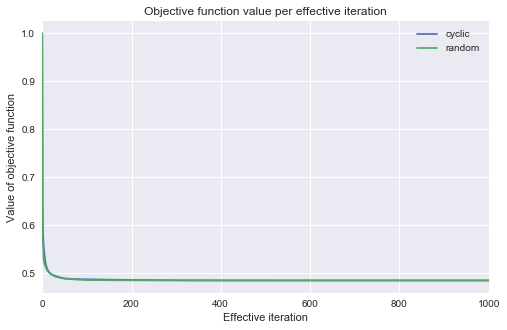

In [58]:
ax = only_full_iterations(obj_values).plot(title="Objective function value per effective iteration")
ax.set_xlabel("Effective iteration")
ax.set_ylabel("Value of objective function")

It's hard to see if the random implementation converges more quickly in the above plot because so much of the plot shows a flat line. I'm curious, so I'll plot just the first iterations here.

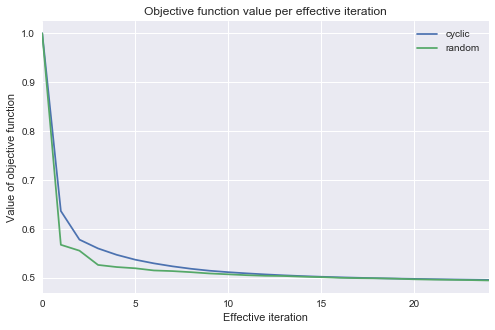

In [75]:
ax = only_full_iterations(obj_values)[:25].plot(title="Objective function value per effective iteration")
ax.set_xlabel("Effective iteration")
ax.set_ylabel("Value of objective function")

## Optimize implementation

*In [1] Section 4.5.2 p. 113-114 two strategies are proposed to speed up the computations: covariance updating
and warm start. Implement either of these (or both, if you are motivated) to speed up your own algorithm*

**TODO all**

# Exercise two

## Generate simulated data

*Generate a simulated data set with 50 examples in each of 5 classes, i.e. 250 observations total. Each example should have 50 features. Be sure to add a mean shift to the observations in each class so that there are five distinct classes.*

In [60]:
num_examples = 50
num_features = 50
mean_vals = [0, 10, 20, 30, 40]
np.random.seed(42)
d = pd.DataFrame(np.vstack([np.random.normal(mean, 
                 size=(num_examples,num_features)) for mean in mean_vals]))
d.insert(0, 'Class', np.repeat(['A','B','C','D','E'], num_examples))
d.shape

(250, 51)

In [61]:
d[:1]

,Class,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,A,0.496714,-0.138264,0.647689,1.52303,-0.234153,-0.234137,1.579213,0.767435,-0.469474,...,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.76304


In [66]:
d_values = d.values[:, 1:num_features+1].astype('float')
d_values_centered = preprocessing.scale(d_values, with_std=False)
d_values_centered.shape

(250, 50)

In [65]:
d_values_centered[0]

array([-19.49620261, -20.11054553, -19.31122118, -18.42769024,
       -20.1806612 , -20.17597982, -18.40108378, -19.29299655,
       -20.4443487 , -19.61552864, -20.49037565, -20.54287502,
       -19.70697955, -21.78506828, -21.8221139 , -20.55230636,
       -21.15546401, -19.66594363, -20.92061749, -21.49926869,
       -18.68856949, -20.21782653, -19.81979138, -21.42437696,
       -20.54725713, -19.82765915, -21.06061019, -19.68364608,
       -20.60194582, -20.25672432, -20.60772055, -18.14535976,
       -19.9694022 , -21.07131093, -19.18567134, -21.22753792,
       -19.7918389 , -21.84700507, -21.30689878, -19.83616755,
       -19.15937416, -19.89229984, -20.12960253, -20.22224917,
       -21.50609712, -20.73388198, -20.41045607, -18.92783009,
       -19.64283395, -21.72147284])

## Compute principal component vectors and compare to sklearn

*Modify your normalized Oja algorithm to output the average of the final ten iterations. Use your own normalized Oja algorithm to compute the first 3 principal component vectors on the 250 observations. Compare your results to the ones obtained with scikit-learn’s PCA algorithm. Print the principal components from both your Oja algorithm and from scikit- learn.*

## Compute vectors to explain 95% of the variance

*Use your own normalized Oja algorithm to compute the principal component vectors that allow one to explain 95% of the variance. This set of vectors should be the smallest possible set of vectors explaining 95% of the variance. Compare your results to the ones obtained with scikit-learn’s PCA algorithm. Print the principal components from both your Oja algorithm and from scikit-learn.*

## Run Oja code on AWS

*Re-launch all of the above computations on AWS. Include the following with your submission: a) screenshot with the output for each question, and b) a screenshot with the results of running the following two commands on your instance.*

**TODO** Run on AWS and insert images as specified.